Deflection at top (w(0)): 1.616710e-20 m
Slope at top (dw/dz(0)): 2.945607e-18 rad
Deflection at bottom (w(H_total)): 4.342698e-23 m
Slope at bottom (dw/dz(H_total)): 3.202016e-21 rad


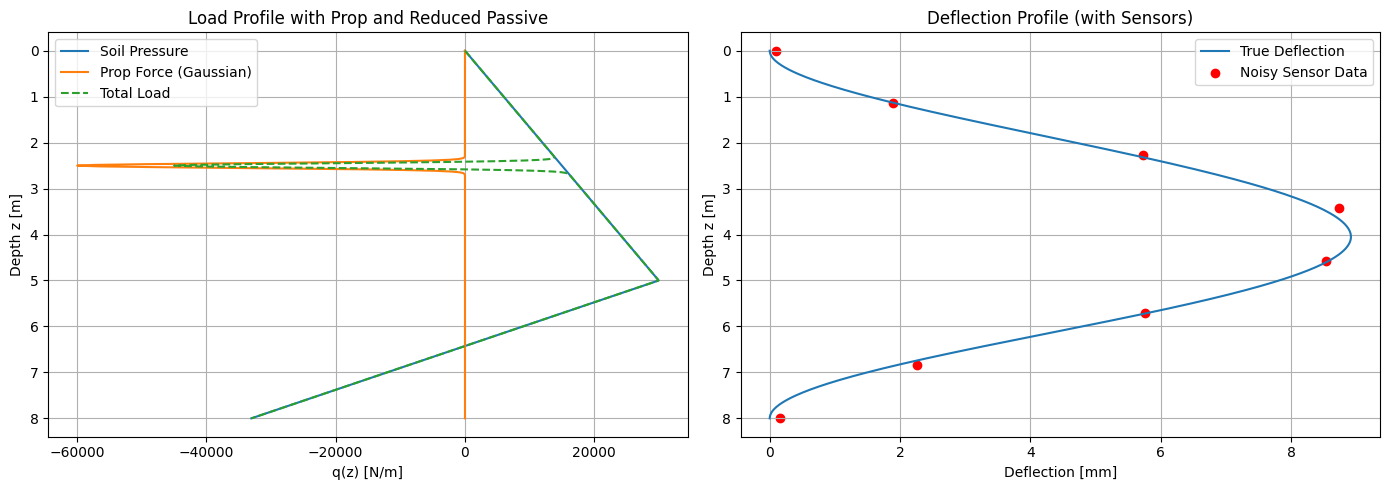

In [424]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_bvp
import pandas as pd
import tensorflow as tf

# --- 1. Wall and Soil Parameters ---
H_exposed = 5.0
D_embed = 3.0
H_total = H_exposed + D_embed
L = H_total
EI = 20e6  # Nm²

gamma = 18.0 * 1e3  # N/m³
Ka = 0.333
Kp_mobilised = 1.5  # Reduced passive pressure coefficient
Kp = 3.0
z_prop = 2.5       # Depth of prop from top [m]
R_prop = 60e3   # N (resisting direction, into wall)

# --- 2. Load Functions ---

# Active + Reduced Passive Pressure
def q_soil(z):
    return np.where(
        z <= H_exposed,
        Ka * gamma * z,
        Ka * gamma * z - Kp_mobilised * gamma * (z - H_exposed)
    )

# Gaussian approximation of point prop force (resisting)
def gaussian_prop(z, z_p, sigma=0.05):
     # scale height so area = total_force
    return  np.exp(-0.5 * ((z - z_p) / sigma) ** 2)


# Total load: Soil pressure - prop resistance
def q_total(z):
    return q_soil(z) - R_prop * gaussian_prop(z, z_prop)

# --- 3. Solve Beam BVP ---

def beam_ode(z, y):
    return np.vstack([y[1], y[2], y[3], q_total(z) / EI])

def bc_bvp(ya, yb):
    return np.array([ya[0], ya[1], yb[0], yb[1]])

z_bvp_sol = np.linspace(0, H_total, 500)
y_init_bvp = np.zeros((4, z_bvp_sol.size))
sol = solve_bvp(beam_ode, bc_bvp, z_bvp_sol, y_init_bvp)

z_plot = np.linspace(0, H_total, 500)
w_true = sol.sol(z_plot)[0]

# --- 4. Sensor Data with Noise ---
num_sensors = 8
sensor_indices = np.linspace(0, len(z_plot) - 1, num_sensors, dtype=int)
z_sensors = z_plot[sensor_indices]
w_sensors = w_true[sensor_indices]
np.random.seed(42)
noise = np.random.normal(0, 0.0002, size=w_sensors.shape)
w_sensors_noisy = w_sensors + noise

# --- 5. Print Boundary Values ---
print(f"Deflection at top (w(0)): {sol.sol(0)[0]:.6e} m")
print(f"Slope at top (dw/dz(0)): {sol.sol(0)[1]:.6e} rad")
print(f"Deflection at bottom (w(H_total)): {sol.sol(H_total)[0]:.6e} m")
print(f"Slope at bottom (dw/dz(H_total)): {sol.sol(H_total)[1]:.6e} rad")

# --- 6. Plot ---
q_soil_vals = q_soil(z_plot)  # kN/m
q_prop_vals = -R_prop * gaussian_prop(z_plot, z_prop)
q_total_vals = q_total(z_plot)
plt.figure(figsize=(14, 5))

# Load Profile
plt.subplot(1, 2, 1)
plt.plot(q_soil_vals, z_plot, label="Soil Pressure")
plt.plot(q_prop_vals, z_plot, label="Prop Force (Gaussian)")
plt.plot(q_total_vals, z_plot, label="Total Load", linestyle="--")
plt.gca().invert_yaxis()
plt.title("Load Profile with Prop and Reduced Passive")
plt.xlabel("q(z) [N/m]")
plt.ylabel("Depth z [m]")
plt.grid(True)
plt.legend()

# Deflection Profile
plt.subplot(1, 2, 2)
plt.plot(w_true * 1000, z_plot, label="True Deflection")
plt.scatter(w_sensors_noisy * 1000, z_sensors, color='red', label="Noisy Sensor Data")
plt.gca().invert_yaxis()
plt.title("Deflection Profile (with Sensors)")
plt.xlabel("Deflection [mm]")
plt.ylabel("Depth z [m]")
plt.grid(True)
plt.legend()


plt.tight_layout()
plt.show()



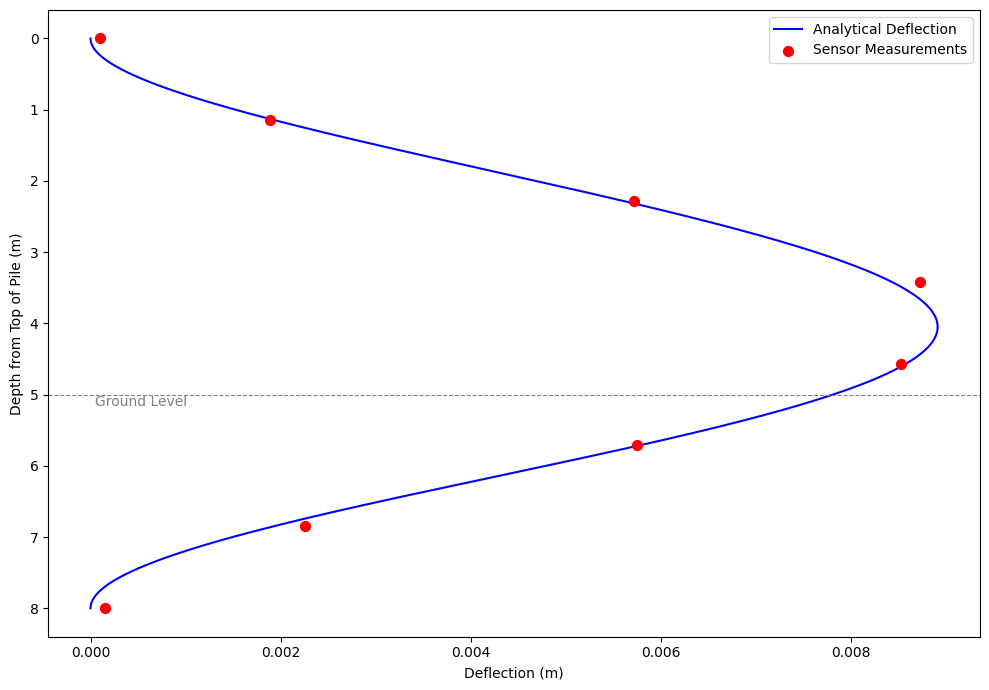

In [425]:
# --- 4. Plotting the Data ---
plt.figure(figsize=(10, 7))

# Plot analytical deflection as a line
plt.plot(w_true, z_plot, label='Analytical Deflection', color='blue', linestyle='-')

# Plot sensor measured deflection as points
plt.scatter(w_sensors_noisy, z_sensors, label='Sensor Measurements', color='red', marker='o', s=50, zorder=5) # zorder to ensure points are on top

#plt.title('Analytical Pile Deflection and noisy sensor Measurements')
plt.xlabel('Deflection (m)')
plt.ylabel('Depth from Top of Pile (m)')
plt.grid(False)
plt.legend()
plt.gca().invert_yaxis() # Invert y-axis to show depth increasing downwards
plt.axhline(H_exposed, color='gray', linestyle='--', linewidth=0.8, label='Ground Level') # Mark ground level
plt.text(plt.xlim()[0] + (plt.xlim()[1] - plt.xlim()[0]) * 0.05, H_exposed + 0.2, 'Ground Level', color='gray', va='bottom')

plt.tight_layout() # Adjust layout to prevent labels from overlapping
plt.show()

In [ ]:
# --- 5. Normalization and Non-dimensionalization Setup ---
z_sensors_norm = z_sensors / L
z_plot_norm = z_plot / L

w_max = np.max(np.abs(w_true)) # Max true deflection for w normalization
# Calculate q_max for q normalization. Using max abs value of true q
q_max = np.max(np.abs(q_total(z_plot)))
q_norm = q_total(z_plot) / q_max

if q_max == 0: # Avoid division by zero if q_true is all zeros (unlikely here)
    q_max = 1.0

w_sensors_norm = w_sensors_noisy / w_max

# ---- 6. Tensor conversion
z_sensors_tf = tf.convert_to_tensor(z_sensors_norm.reshape(-1, 1), dtype=tf.float32)
w_sensors_tf = tf.convert_to_tensor(w_sensors_norm.reshape(-1, 1), dtype=tf.float32)
z_uniform = np.linspace(0, 1, 180)
# 10 extra points concentrated around z = 0.3125 (±0.01)
z_cluster = np.linspace(0.3025, 0.3225, 20)
# Combine and sort
z_colloc = np.sort(np.concatenate([z_uniform, z_cluster])).reshape(-1, 1)
z_colloc_tf = tf.convert_to_tensor(z_colloc, dtype=tf.float32)

44996.94705315823

In [427]:
# --- 7. NN Model ---
def make_model():
    return tf.keras.Sequential([
        tf.keras.layers.Input(shape=(1,)),
        tf.keras.layers.Dense(50, activation='swish'),
        tf.keras.layers.Dense(50, activation='swish'),
        tf.keras.layers.Dense(50, activation='swish'),
        tf.keras.layers.Dense(1)
    ])

model = make_model()

# --- 8. Initialize b1, c1, b2, c2
m_a = tf.Variable(0.5, dtype=tf.float32)
m_p = tf.Variable(1, dtype=tf.float32)
m_prop = tf.Variable(1, dtype=tf.float32)


# --- 9. Learning Rate Scheduler ---
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3, # Slightly lower initial LR
    decay_steps=10000,
    decay_rate=0.9
)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)



In [428]:
# --- 10. Derivative function ---
def compute_derivatives(z_input):
    with tf.GradientTape() as tape4:
        tape4.watch(z_input)
        with tf.GradientTape() as tape3:
            tape3.watch(z_input)
            with tf.GradientTape() as tape2:
                tape2.watch(z_input)
                with tf.GradientTape() as tape1:
                    tape1.watch(z_input)
                    w_norm = model(z_input) # This is w_normalized
                dw_norm = tape1.gradient(w_norm, z_input)
            d2w_norm = tape2.gradient(dw_norm, z_input)
        d3w_norm = tape3.gradient(d2w_norm, z_input)
    d4w_norm = tape4.gradient(d3w_norm, z_input)
    return w_norm, dw_norm, d2w_norm, d3w_norm, d4w_norm

#--- 11.  Piecewise q(z) - now outputs normalized q
def gaussian_prop_tf(z, z_p, sigma=0.005):
    return tf.exp(-0.5 * tf.square((z - z_p) / sigma))

def piecewise_q_normalized(z_phys):
    q_prop =  (R_prop) * gaussian_prop_tf(z_phys, z_prop)
    q_total = tf.where(z_phys <= H_exposed, (m_a * gamma * Ka * z_phys - q_prop), (m_a * gamma * Ka * z_phys - m_p*gamma*Kp*(z_phys-H_exposed)))
    return q_total / q_max


In [ ]:
beta = tf.constant(0.9, dtype=tf.float32)  # Smoothing factor
w_data = tf.Variable(1.0, dtype=tf.float32)
w_phys = tf.Variable(0.5, dtype=tf.float32)
w_bc = tf.Variable(1.0, dtype=tf.float32)
w_all = tf.Variable(1.0, dtype=tf.float32)

Use_Average = True

In [ ]:
@tf.function
def train_step(epoch_val):
    with tf.GradientTape(persistent=True) as tape2:
        with tf.GradientTape(persistent=True) as tape1:
            z_phys_colloc = z_colloc_tf * L
            w_norm, dw_norm, _, _, d4w = compute_derivatives(z_colloc_tf)
            q_hat_norm = piecewise_q_normalized(z_phys_colloc)

            physics_residual = d4w * (EI * w_max / (L**4 * q_max)) - q_hat_norm
            physics_loss = tf.reduce_mean(tf.square(physics_residual)) * 10

            w_pred, _, _, _, _ = compute_derivatives(z_sensors_tf)
            data_loss = tf.reduce_mean(tf.square(w_pred - w_sensors_tf))

            bc_loss = tf.square(w_norm[0]) + tf.square(w_norm[-1]) + tf.square(dw_norm[0]) + tf.square(dw_norm[-1])
            
        if epoch_val % 10 == 0:
            vars = model.trainable_variables
            vars_weights = [var for var in vars if ('kernel' in var.name) or ('weight:' in var.name)]

            grad_res = tape1.gradient(physics_loss, vars_weights)
            grad_data = tape1.gradient(data_loss, vars_weights)
            grad_bcs = tape1.gradient(bc_loss, vars_weights)

            grad_res_flatten = tf.concat([tf.reshape(g, [-1]) for g in grad_res], axis=0)
            grad_data_flatten = tf.concat([tf.reshape(g, [-1]) for g in grad_data], axis=0)
            grad_bcs_flatten = tf.concat([tf.reshape(g, [-1]) for g in grad_bcs], axis=0)
            grad_all_flatten = grad_data_flatten + grad_bcs_flatten

            max_grad_res = tf.reduce_max(abs(grad_res_flatten))
            mean_grad_data = tf.reduce_mean(abs(grad_data_flatten))
            mean_grad_bcs = tf.reduce_mean(abs(grad_bcs_flatten))
            mean_grad_all = tf.reduce_mean(abs(grad_all_flatten))

            w_data_hat = max_grad_res / mean_grad_data
            w_bc_hat = max_grad_res / mean_grad_bcs
            w_all_hat = max_grad_res / mean_grad_all
            
            '''tf.print("max_grad:", max_grad_res)
            tf.print("mean_grad_data:", mean_grad_data)
            tf.print("mean_grad_bcs:", mean_grad_bcs)

            tf.print("w_data_hat:", w_data_hat)
            tf.print("w_bc_hat:", w_bc_hat)'''
            
            w_all.assign(w_all * beta + w_all_hat * (1 - beta))    
            w_all.assign(tf.clip_by_value(w_all, 0.01, 1000.0)) #adding cap to avoid exploding weights
            
            w_data.assign(w_data * beta + w_data_hat * (1 - beta))
            w_phys.assign(1.0)
            w_bc.assign(w_bc * beta + w_bc_hat * (1 - beta))   
            
            if Use_Average:          
                w_data.assign(w_all)
                w_bc.assign(w_all)

        total_loss = (
            w_data * data_loss +
            w_phys * physics_loss +
            w_bc * bc_loss
        )

    variables = model.trainable_variables + [m_a, m_p]
    grads = tape2.gradient(total_loss, variables)
    optimizer.apply_gradients(zip(grads, variables))
    del tape
    return total_loss, data_loss, physics_loss, bc_loss, w_data, w_bc, w_all


In [ ]:
TOTAL_EPOCHS = 15000

history = {k: [] for k in ["loss", "data", "phys", "bc"]}
history_weights = {k: [] for k in ["w_data", "w_bc", "w_all"]}
history_params = {"m_a": [], "m_p": []}

for epoch in range(TOTAL_EPOCHS):
    loss, data_l, phys_l, bc_l, w_data, w_bc, w_all = train_step(tf.constant(epoch, dtype=tf.int32))

    history["loss"].append(float(loss.numpy()))
    history["data"].append(float(data_l.numpy()))
    history["phys"].append(float(phys_l.numpy()))
    history["bc"].append(float(bc_l.numpy()))
    history_weights["w_data"].append(float(w_data.numpy()))
    history_weights["w_bc"].append(float(w_bc.numpy()))
    history_weights["w_all"].append(float(w_all.numpy()))
    history_params["m_a"].append(m_a.numpy())
    history_params["m_p"].append(m_p.numpy())
    #history_params["m_prop"].append(m_prop.numpy())

    if epoch % 1000 == 0 or epoch in [N_PHYSICS_EPOCHS - 1, N_PHYSICS_EPOCHS,
                                      N_BC_EPOCHS - 1, N_BC_EPOCHS,
                                      TOTAL_EPOCHS - 1]:
        print(f"Epoch {epoch:5d} | Total: {loss.numpy().item():.2e} | Data: {data_l.numpy().item():.2e} | Phys: {phys_l.numpy().item():.2e} | BC: {bc_l.numpy().item():.2e} | w_data: {w_data.numpy().item():.2e}, w_bc: {w_bc.numpy().item():.2e}, w_all: {w_all.numpy().item():.2e}  ")


/var/folders/t1/n85qy3554dzf2j8ssgfp_2540000gn/T/ipykernel_87301/517337634.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  history["loss"].append(float(loss.numpy()))
/var/folders/t1/n85qy3554dzf2j8ssgfp_2540000gn/T/ipykernel_87301/517337634.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  history["bc"].append(float(bc_l.numpy()))


Epoch     0 | Total: 1.04e+01 | Data: 3.68e-01 | Phys: 1.01e+01 | BC: 4.27e-03 | w_data: 9.02e-01, w_bc: 9.02e-01, w_all: 9.02e-01  
Epoch  1000 | Total: 2.41e+00 | Data: 7.51e-04 | Phys: 1.50e+00 | BC: 1.63e-04 | w_data: 1.00e+03, w_bc: 1.00e+03, w_all: 1.00e+03  
Epoch  2000 | Total: 1.38e+00 | Data: 2.83e-04 | Phys: 8.63e-01 | BC: 2.63e-04 | w_data: 9.46e+02, w_bc: 9.46e+02, w_all: 9.46e+02  
Epoch  3000 | Total: 1.16e+00 | Data: 2.72e-04 | Phys: 7.04e-01 | BC: 3.55e-04 | w_data: 7.28e+02, w_bc: 7.28e+02, w_all: 7.28e+02  
Epoch  4000 | Total: 2.49e+00 | Data: 2.42e-04 | Phys: 6.17e-01 | BC: 1.82e-03 | w_data: 9.08e+02, w_bc: 9.08e+02, w_all: 9.08e+02  
Epoch  5000 | Total: 8.10e-01 | Data: 2.32e-04 | Phys: 5.51e-01 | BC: 2.66e-05 | w_data: 1.00e+03, w_bc: 1.00e+03, w_all: 1.00e+03  
Epoch  6000 | Total: 7.56e-01 | Data: 2.25e-04 | Phys: 5.07e-01 | BC: 2.34e-05 | w_data: 1.00e+03, w_bc: 1.00e+03, w_all: 1.00e+03  
Epoch  7000 | Total: 7.01e-01 | Data: 2.19e-04 | Phys: 4.70e-01 | BC:

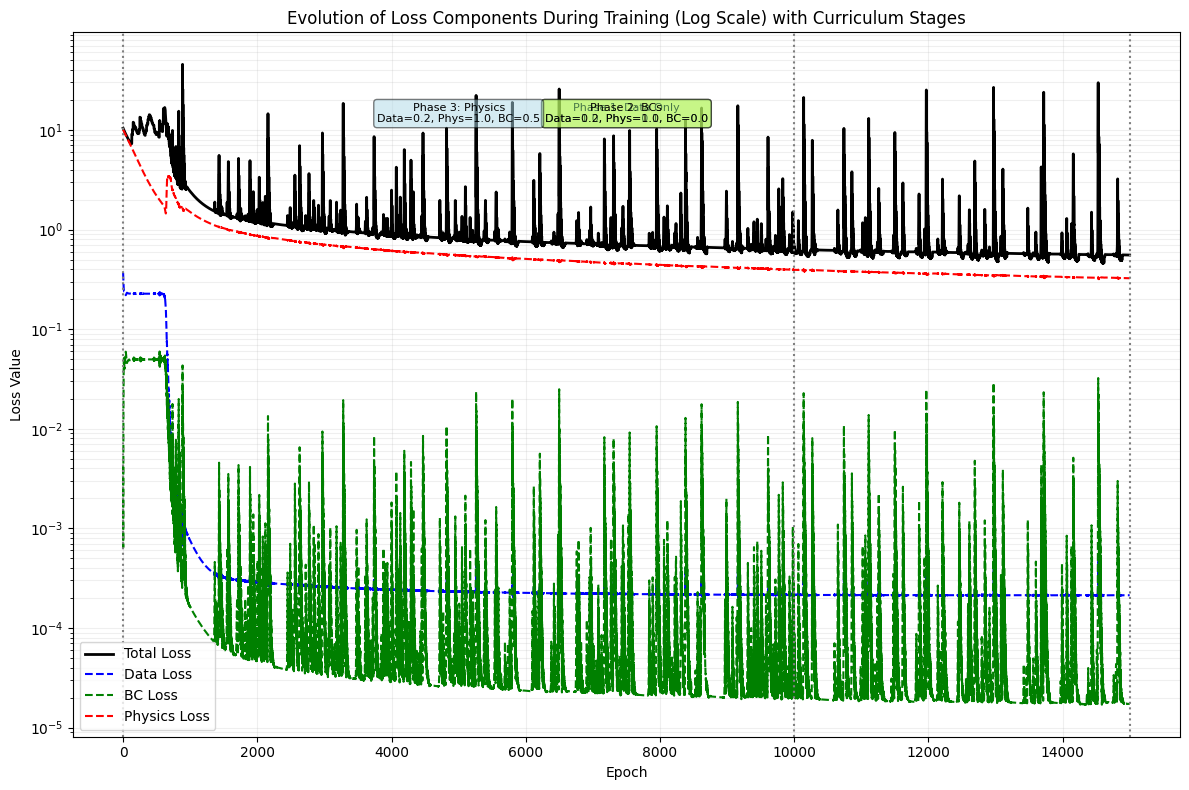

In [432]:
import matplotlib.pyplot as plt
import numpy as np

# Define curriculum stage weights for annotation
W1_DATA, W1_PHYS, W1_BC = 1.0, 0.1, 0.0     # Phase 1
W2_DATA, W2_PHYS, W2_BC = 0.2, 1.0, 0.0     # Phase 2
W3_DATA, W3_PHYS, W3_BC = 0.2, 1.0, 0.5     # Phase 3

# --- Plotting Loss History with Stages ---
plt.figure(figsize=(12, 8))

# Plot Total Loss
plt.plot(history["loss"], label="Total Loss", color='black', linewidth=2)

# Plot Individual Loss Components
plt.plot(history["data"], label="Data Loss", color='blue', linestyle='--')
plt.plot(history["bc"], label="BC Loss", color='green', linestyle='--')
plt.plot(history["phys"], label="Physics Loss", color='red', linestyle='--')
# Uncomment if you have continuity loss
# plt.plot(history["cont"], label="Continuity Loss", color='purple', linestyle='--')

plt.xlabel("Epoch")
plt.ylabel("Loss Value")
plt.title("Evolution of Loss Components During Training (Log Scale) with Curriculum Stages")
plt.yscale('log')
plt.legend()
plt.grid(True, which="both", ls="-", alpha=0.2)

# Vertical lines to mark transitions
plt.axvline(N_DATA_ONLY_EPOCHS, color='gray', linestyle=':', linewidth=1.5)
plt.axvline(N_BC_EPOCHS, color='gray', linestyle=':', linewidth=1.5)
plt.axvline(N_PHYSICS_EPOCHS, color='gray', linestyle=':', linewidth=1.5)

# --- Annotations with Curriculum Weights ---
ymin, ymax = plt.ylim()
text_y_pos_log = 10 ** (np.log10(ymax) - 0.1 * (np.log10(ymax) - np.log10(ymin)))  # 90% of height

# Phase 1: Data Only
plt.text(N_DATA_ONLY_EPOCHS / 2, text_y_pos_log,
         f"Phase 1: Data Only\nData={W1_DATA:.1f}, Phys={W1_PHYS:.1f}, BC={W1_BC:.1f}",
         ha='center', va='top',
         bbox=dict(boxstyle="round,pad=0.3", fc='yellow', alpha=0.5), fontsize=8)

# Phase 2: Add BC
plt.text(N_DATA_ONLY_EPOCHS + (N_BC_EPOCHS - N_DATA_ONLY_EPOCHS) / 2, text_y_pos_log,
         f"Phase 2: BCs\nData={W2_DATA:.1f}, Phys={W2_PHYS:.1f}, BC={W2_BC:.1f}",
         ha='center', va='top',
         bbox=dict(boxstyle="round,pad=0.3", fc='lightgreen', alpha=0.5), fontsize=8)

# Phase 3: Full Physics
plt.text(N_BC_EPOCHS + (N_PHYSICS_EPOCHS - N_BC_EPOCHS) / 2, text_y_pos_log,
         f"Phase 3: Physics\nData={W3_DATA:.1f}, Phys={W3_PHYS:.1f}, BC={W3_BC:.1f}",
         ha='center', va='top',
         bbox=dict(boxstyle="round,pad=0.3", fc='lightblue', alpha=0.5), fontsize=8)

plt.tight_layout()
plt.show()


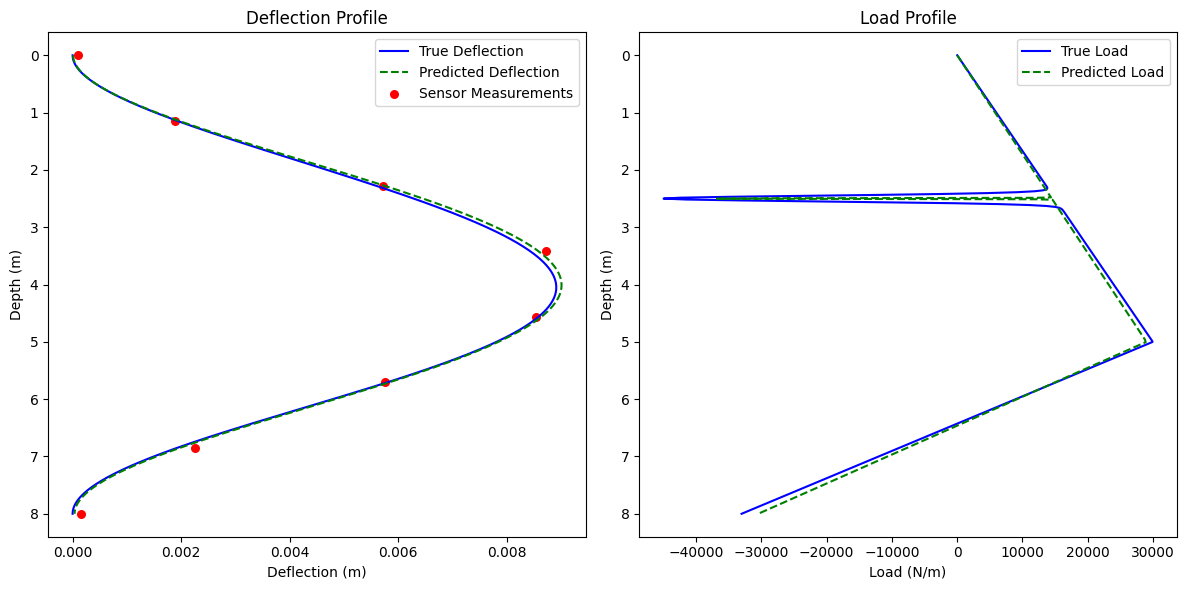

In [433]:
# --- Post-Training: Predict Deflection and Load ---
w_pred_norm = model(z_colloc_tf).numpy().flatten()
w_pred_unnorm = w_pred_norm * w_max
q_pred_unnorm = piecewise_q_normalized(z_colloc_tf * L).numpy().flatten() * q_max

plt.figure(figsize=(12, 6))

# --- Plot Deflection Profile ---
plt.subplot(1, 2, 1)
plt.plot(w_true, z_plot, label='True Deflection', color='blue')
plt.plot(w_pred_unnorm, z_colloc_tf.numpy().flatten() * L, label='Predicted Deflection', color='green', linestyle='--')
plt.scatter(w_sensors_noisy, z_sensors, label='Sensor Measurements', color='red', marker='o', s=30)
plt.gca().invert_yaxis()
plt.xlabel('Deflection (m)')
plt.ylabel('Depth (m)')
plt.title('Deflection Profile')
plt.legend()
plt.grid(False)

# --- Plot Load Profile ---
plt.subplot(1, 2, 2)
plt.plot(q_total_vals, z_plot, label='True Load', color='blue')
plt.plot(q_pred_unnorm, z_colloc_tf.numpy().flatten() * L, label='Predicted Load', color='green', linestyle='--')
plt.gca().invert_yaxis()
plt.xlabel('Load (N/m)')
plt.ylabel('Depth (m)')
plt.title('Load Profile')
plt.legend()
plt.grid(False)

plt.tight_layout()
plt.show()


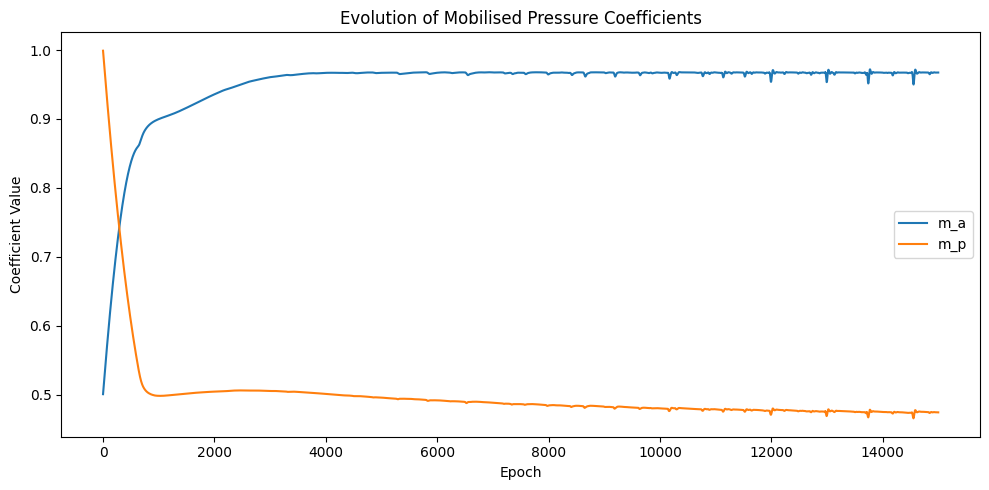


Learned Load Parameters:
m_a: 0.9674
m_p: 0.4746
m_prop: 1.0000


In [434]:
epochs = np.arange(TOTAL_EPOCHS)

plt.figure(figsize=(10, 5))
plt.plot(history_params["m_a"], label="m_a")
plt.plot(history_params["m_p"], label="m_p")
#plt.plot(epochs, history_params["m_prop"], label="m_prop")
plt.title("Evolution of Mobilised Pressure Coefficients")
plt.xlabel("Epoch")
plt.ylabel("Coefficient Value")
plt.legend()
plt.grid(False)
plt.tight_layout()
plt.show()

print("\nLearned Load Parameters:")
print(f"m_a: {m_a.numpy():.4f}")
print(f"m_p: {m_p.numpy():.4f}")
print(f"m_prop: {m_prop.numpy():.4f}")


In [435]:
from sklearn.metrics import r2_score

w_pred_full = model(z_plot_norm.reshape(-1, 1)).numpy().flatten() * w_max
r2 = r2_score(w_true, w_pred_full)
print("R² score:", r2)



R² score: 0.9991919068216771
